# Predict customer churn

Acquiring new customers is important for a business, but it is just as important (and less expensive) to retain existing customers. However, customer retention teams have limited resources and are unable to devote the same level of attention to every customer. Businesses need to determine which customers are more likely to churn so they can prioritize their retention efforts. This notebook outlines how to build models to predict customers that are at risk to churn by creating a prioritized list of customers at high risk of churn for a retention team to contact.

## Business overview

### What is churn?

Customer churn needs to be defined. It can either be a period of inactivity or a request to cancel a subscription. Some examples of churn are customers who:

- Did not visit a retailer's store in 'X' days.
- Cancel their telecom contracts.
- Close their bank accounts. 
- Do not renew their insurance policy.
    

### Operationalization gap

**What is the ideal time to intervene before the churn happens?**
    
When predicting customer churn, it is crucial to identify the high churn-risk customers at the right time; this is the operationalization gap. If a high churn-risk customer is identified too late, then it's unlikely that you can prevent churn via intervention. If the customer is contacted too early, the effectiveness of intervention might be too low. The appropriate time required for the intervention needs to be incorporated into the model setup to predict churn at the right time. For instance, if the right time for intervention in this use case is one month before the churn, then training data should include data of the historical churned customers only until one month before churn. This is the prediction point.

### Use case outline

**Desired outcomes:**

- Prevent churn
- Optimally target customers at high risk of customers 
- Increase revenue by preventing churn

**Relevant metrics:**

- LTV of customer
- Cost of intervention strategy
- Effectiveness of intervention strategy

### Solution value

Identifying customers at high risk of churn is only the first step in customer retention. The second step is the business strategy. Usually, intervention strategies come at a cost. Common intervention strategies include cold calls (low cost) and discount coupons (high cost). Across high-risk customers, different strategies can be adapted based on the degree of risk and/or customer value. A cold call may suffice for a low value-high risk customer, while a high value-high risk customer can be extended a costlier intervention strategy like a discount coupon.

## Data

### Dataset description

[The sample training dataset](Telco_churn_with_snapshots_target.csv) contains two years of historical data snapshotted every month.

### Dataset structure

- Target: Churn/Active

- Required features:
    - Customer monthly or weekly activity
        - Frequency of usage
        - Recency of usage
        - Money spent per use
        - Customer support interactions
    
    - Product or service pricing details
        - Current subscription price
        - Historical subscription price changes
        - Subscription duration
        - Sub-products or addons 
    
    - Customer details
        - Customer tenure
        - Customer demographics
    
    
- Data granularity: One row per customer per month

- Additional data, if available, is beneficial (such as competitor pricing details)

### Data preparation

- Example tables
- Different use-cases require different data prep
- Secondary datasets like Customer activity
- Expected structure input for modelling to continue
- Show target leakage (optional)

#### Define the target

For this use case, the target needs to be defined by the business case - it can be either a period of inactivity or a request to cancel the subscription. Both of these actions indicate churn.

In the example training dataset, the target is based on a request to cancel a subscription. The intervention for churn prevention is assumed to be done at least one month before the subscription cancellation. The earliest intervention can be up to three months before cancellation. Therefore, the target definition would be customers who might churn between 1-3 months from the prediction date so that the intervention team has 1-3 months to contact and try to retain the customer.

#### Define the unit of analysis

**Method 1: Customer-month level**

Use this time-based method when you expect that customer behavior changes over time, especially before churn. Each row represents a customer's data for a particular month. Each customer will be divided into multiple rows, with each row representing the customer's activity or profile based on the data for that month. The features need to be carefully engineered to ensure that future data is not used to calculate features for a particular month.

**Method 2: Customer level**

Use this method if you expect that customer behavior does not change much over time. Each row represents a customer's data. Use the latest date in the data for active customers. For churned customers, use the latest data before churn.

In the training dataset, the data is at the customer-month level (method 1). At prediction time, all the customers are scored every month so that the intervention team can contact the customers with high churn-risk predictions.

In the example data, assume an operationalization gap of 1 month. Churn is defined as someone who churns within three months from the prediction date. The unit of analysis is customer-month. The dataset contains data for every customer every month, from start to churn (for churned customers), or to the last month in the dataset (for non-churned customers).

## Workflow

### Import libraries

In [2]:
import datarobot as dr
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas as pd
from pandasql import sqldf

dr_dark_blue = "#08233F"
dr_blue = "#1F77B4"
dr_orange = "#FF7F0E"
dr_red = "#BE3C28"

### Define functions

Before proceeding, review the functions outlined below. They are used throughout the notebook.

In [30]:
# flake8: noqa


def create_churn_target_cancellation(
    df,
    id_col,
    date_col,
    cancellation_col,
    cancellation_val,
    time_interval="months",
    operationalization_gap=1,
    churn_period=3,
):
    df = df.copy()
    # Sort the data based on date within each ID
    df.sort_values([id_col, date_col], inplace=True)

    # Create a SQL query to account for operationalization gap and churn period
    query = f'SELECT t1.{id_col}, t1.{date_col}, \
                    MAX(CASE WHEN t2.{cancellation_col} == \
                    "{cancellation_val}" THEN 1 ELSE 0 END) as Target \
                  FROM df t1 \
                  LEFT JOIN df t2 \
                  ON t1.{id_col} = t2.{id_col} \
                  AND t2.{date_col} <= DATE(t1.{date_col}, "{churn_period} months") \
                  AND t2.{date_col} >= t1.{date_col} \
                  GROUP BY t1.{id_col}, t1.{date_col}, t1.{cancellation_col} \
                  HAVING NOT((COUNT(*) <= {operationalization_gap}) \
                  AND (MAX(CASE WHEN t2.{cancellation_col} == \
                    "{cancellation_val}" THEN 1 ELSE 0 END) == 1)) \
              '

    # Run the SQL query using sqldf package within python
    df_transform = sqldf(query)
    df_transform[date_col] = pd.to_datetime(df_transform[date_col])

    # Remove rows where target cannot be defined (due to operationalization gap)
    df_transform = df_transform.loc[~df_transform["Target"].isna()]
    df_transform = df_transform.loc[
        df_transform[date_col] <= max(df_transform[date_col]) - pd.DateOffset(months=churn_period)
    ]
    return df_transform


def matplotlib_pair_histogram(labels, counts, target_avgs, bin_count, ax1, feature):
    # Rotate categorical labels
    if feature.feature_type in ["Categorical", "Text"]:
        ax1.tick_params(axis="x", rotation=45)
    ax1.set_ylabel(feature.name, color=dr_blue)
    ax1.bar(labels, counts, color=dr_blue)
    # Instantiate a second axes that shares the same x-axis
    ax2 = ax1.twinx()
    ax2.set_ylabel(target_feature_name, color=dr_orange)
    ax2.plot(labels, target_avgs, marker="o", lw=1, color=dr_orange)
    ax1.set_facecolor(dr_dark_blue)
    title = "Histogram for {} ({} bins)".format(feature.name, bin_count)
    ax1.set_title(title)


def draw_feature_histogram(feature_name, bin_count, project, target_feature_name):
    feature = dr.Feature.get(project.id, feature_name)
    # Retrieve downsampled histogram data from server
    # based on desired bin count
    data = feature.get_histogram(bin_count).plot
    labels = [row["label"] for row in data]
    counts = [row["count"] for row in data]
    target_averages = [row["target"] for row in data]
    f, axarr = plt.subplots()
    f.set_size_inches((10, 4))
    matplotlib_pair_histogram(labels, counts, target_averages, bin_count, axarr, feature)


def plot_dr_roc_curve(project, model, source="holdout"):
    if source == "holdout":
        project.unlock_holdout()
    roc = model.get_roc_curve(source)
    df = pd.DataFrame(roc.roc_points)

    dr_dark_blue = "#08233F"
    dr_roc_green = "#03c75f"
    white = "#ffffff"
    dr_purple = "#65147D"
    dr_dense_green = "#018f4f"
    dr_blue = "#1F77B4"
    dr_orange = "#FF7F0E"
    dr_red = "#BE3C28"

    fig = plt.figure(figsize=(8, 8))
    axes = fig.add_subplot(1, 1, 1, facecolor=dr_dark_blue)

    plt.scatter(df.false_positive_rate, df.true_positive_rate, color=dr_roc_green)
    plt.plot(df.false_positive_rate, df.true_positive_rate, color=dr_roc_green)
    plt.plot([0, 1], [0, 1], color=white, alpha=0.25)
    plt.title("ROC curve")
    plt.xlabel("False Positive Rate (Fallout)")
    plt.xlim([0, 1])
    plt.ylabel("True Positive Rate (Sensitivity)")
    plt.ylim([0, 1])


def get_dr_confusion_matrix(project, model, source="holdout", threshold=None):
    if source == "holdout":
        project.unlock_holdout()

    roc = model.get_roc_curve(source)
    if threshold is None:
        threshold = roc.get_best_f1_threshold()
    metrics = roc.estimate_threshold(threshold)
    roc_df = pd.DataFrame(
        {
            "Predicted Negative": [
                metrics["true_negative_score"],
                metrics["false_negative_score"],
                metrics["true_negative_score"] + metrics["false_negative_score"],
            ],
            "Predicted Positive": [
                metrics["false_positive_score"],
                metrics["true_positive_score"],
                metrics["true_positive_score"] + metrics["false_positive_score"],
            ],
            "Total": [
                metrics["true_negative_score"] + metrics["false_positive_score"],
                metrics["false_negative_score"] + metrics["true_positive_score"],
                metrics["true_negative_score"]
                + metrics["false_negative_score"]
                + metrics["true_positive_score"]
                + metrics["false_positive_score"],
            ],
        }
    )
    roc_df.index = pd.MultiIndex.from_tuples([("Actual", "-"), ("Actual", "+"), ("Total", "")])
    roc_df.columns = pd.MultiIndex.from_tuples(
        [("Predicted", "-"), ("Predicted", "+"), ("Total", "")]
    )
    roc_df.style.set_properties(**{"text-align": "right"})
    return roc_df


def plot_feature_impact(model):
    feature_impacts = model.get_or_request_feature_impact()

    dr_dark_blue = "#08233F"
    dr_roc_green = "#03c75f"
    white = "#ffffff"
    dr_purple = "#65147D"
    dr_dense_green = "#018f4f"
    dr_blue = "#1F77B4"
    dr_orange = "#FF7F0E"
    dr_red = "#BE3C28"

    # Formats the ticks from a float into a percent
    percent_tick_fmt = mtick.PercentFormatter(xmax=1.0)

    impact_df = pd.DataFrame(feature_impacts)[:10]
    impact_df.sort_values(by="impactNormalized", ascending=True, inplace=True)

    # Positive values are blue, negative are red
    bar_colors = impact_df.impactNormalized.apply(lambda x: dr_red if x < 0 else dr_blue)

    ax = impact_df.plot.barh(
        x="featureName", y="impactNormalized", legend=False, color=bar_colors, figsize=(10, 14)
    )
    ax.xaxis.set_major_formatter(percent_tick_fmt)
    ax.xaxis.set_tick_params(labeltop=True)
    ax.xaxis.grid(True, alpha=0.2)
    ax.set_facecolor(dr_dark_blue)

    plt.ylabel("")
    plt.xlabel("Effect")
    plt.xlim((None, 1))  # Allow for negative impact
    plt.title("Feature Impact", y=1.04)

### Connect to DataRobot

Read more about different options for [connecting to DataRobot from the client](https://docs.datarobot.com/en/docs/api/api-quickstart/api-qs.html).

In [ ]:
# If the config file is not in the default location described in the API Quickstart guide, then you will need to call
# dr.Client(config_path='path-to-drconfig.yaml')

### Import data

In [4]:
data_path = "Telco_churn_with_snapshots_target.csv"

df_target = pd.read_csv(data_path, parse_dates=["Date"])
df_target.sort_values(["customerID", "Date"], inplace=True)

In [5]:
df_target.head()

customerID       Date Churn
48332  0002-ORFBO 2021-04-01    No
43248  0002-ORFBO 2021-05-01    No
38006  0002-ORFBO 2021-06-01    No
32605  0002-ORFBO 2021-07-01    No
27081  0002-ORFBO 2021-08-01    No

In [6]:
# Select the target based on the util function
df_target_final = create_churn_target_cancellation(
    df=df_target,
    id_col="customerID",
    date_col="Date",
    cancellation_col="Churn",
    cancellation_val="Yes",
    time_interval="months",
    operationalization_gap=1,
    churn_period=2,
)

In [7]:
df_target_final.shape

(100509, 3)

In [8]:
df_target_final["Target"].value_counts()

0    99149
1     1360
Name: Target, dtype: int64

Use the cell below to join other features for training. Access the dataset used [here](Telco_churn_with_snapshots_features.csv).

In [9]:
# Join other features for training
join_path = "Telco_churn_with_snapshots_features.csv"
df_train = pd.read_csv(join_path, parse_dates=["Date"])
df_train = df_train.merge(df_target_final, on=["customerID", "Date"], how="right")

In [10]:
df_train.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  0002-ORFBO  Female              0     Yes        Yes       1          Yes   
1  0002-ORFBO  Female              0     Yes        Yes       2          Yes   
2  0002-ORFBO  Female              0     Yes        Yes       3          Yes   
3  0002-ORFBO  Female              0     Yes        Yes       4          Yes   
4  0002-ORFBO  Female              0     Yes        Yes       5          Yes   

  MultipleLines InternetService OnlineSecurity  ... TechSupport StreamingTV  \
0            No             DSL             No  ...         Yes         Yes   
1            No             DSL             No  ...         Yes         Yes   
2            No             DSL             No  ...         Yes         Yes   
3            No             DSL             No  ...         Yes         Yes   
4            No             DSL             No  ...         Yes         Yes   

  StreamingMovies  Contract PaperlessBilling PaymentMethod MonthlyCharges  \
0              No  One year              Yes  Mailed check            2.9   
1              No  One year              Yes  Mailed check           65.6   
2              No  One year              Yes  Mailed check           65.6   
3              No  One year              Yes  Mailed check           65.6   
4              No  One year              Yes  Mailed check           65.6   

  TotalCharges       Date  Target  
0          2.9 2021-04-01       0  
1         68.5 2021-05-01       0  
2        134.1 2021-06-01       0  
3        199.7 2021-07-01       0  
4        265.3 2021-08-01       0  

[5 rows x 22 columns]

In [11]:
# Upload the dataset to the AI Catalog
dataset = dr.Dataset.create_from_in_memory_data(df_train)
dataset.modify(name="Telco_churn_with_snapshots")

### Create a project

In [13]:
project = dr.Project.create_from_dataset(dataset.id, project_name="Telco_churn_with_snapshots")

Use the cell below to view the project in the DataRobot application.

In [16]:
project.get_leaderboard_ui_permalink()

'https://app.datarobot.com/projects/63a153f18ecbdc254489a4bd/models'

You can check the target distribution by navigating to **Data > Feature > Histogram**.

<AxesSubplot:>

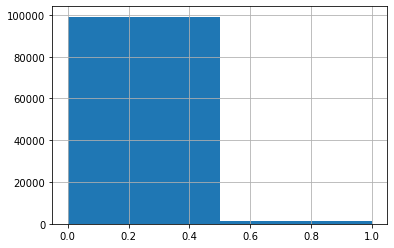

In [17]:
df_train["Target"].hist(bins=2)

To view the distribution of the target over time, go to **Data > Feature > Over Time**.

<AxesSubplot:xlabel='Date'>

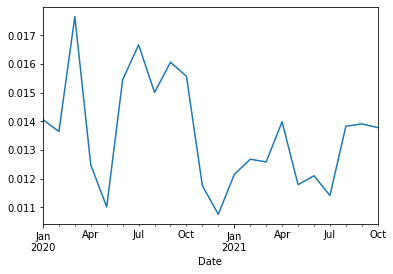

In [18]:
df_train.groupby("Date")["Target"].mean().plot()

## Modeling

### Configure modeling settings

In [19]:
settings = {}
settings["datetime_partition_column"] = "Date"  # Date Column which is used to partition the data
settings["number_of_backtests"] = 3  # Number of backtests for the model to create
settings["gap_duration"] = "P0Y1M0DT0H0M0S"  # Gap between training and validation folds
settings["validation_duration"] = "P0Y3M0DT0H0M0S"  # Duration of validation data
settings["target"] = "Target"  # Name of the target feature
settings[
    "worker_count"
] = -1  # Number of modeling workers to use, -1 will use all available workers

Use the cell below to create time-based partitions.

In [20]:
spec = dr.DatetimePartitioningSpecification(
    datetime_partition_column=settings["datetime_partition_column"],
    number_of_backtests=settings["number_of_backtests"],
    gap_duration=settings["gap_duration"],
    validation_duration=settings.get("validation_duration"),
)

### Initiate Autopilot

In [21]:
project.set_target(
    settings["target"],
    partitioning_method=spec,
    worker_count=settings["worker_count"],
    max_wait=20000,
)
project.wait_for_autopilot(timeout=None, verbosity=dr.VERBOSITY_LEVEL.SILENT)

### Retrieve models

In [23]:
models = project.get_models(with_metric="AUC")
models

[Model('Elastic-Net Classifier (mixing alpha=0.5 / Binomial Deviance)'),
 Model('Elastic-Net Classifier (mixing alpha=0.5 / Binomial Deviance)'),
 Model('Elastic-Net Classifier (L2 / Binomial Deviance)'),
 Model('Elastic-Net Classifier (mixing alpha=0.5 / Binomial Deviance)'),
 Model('Elastic-Net Classifier (mixing alpha=0.5 / Binomial Deviance)'),
 Model('Elastic-Net Classifier (L2 / Binomial Deviance)'),
 Model('Light Gradient Boosting on ElasticNet Predictions '),
 Model('Light Gradient Boosting on ElasticNet Predictions '),
 Model('Generalized Additive2 Model'),
 Model('Light Gradient Boosted Trees Classifier with Early Stopping'),
 Model('eXtreme Gradient Boosted Trees Classifier with Early Stopping'),
 Model('Generalized Additive2 Model'),
 Model('Keras Slim Residual Neural Network Classifier using Training Schedule (1 Layer: 64 Units)'),
 Model('RandomForest Classifier (Gini)')]

In [25]:
jobs = [
    dr.DatetimeModel.get(project.id, m.id).score_backtests()
    for m in models[:7]
    if not m.is_frozen
    and m.model_category != "blend"
    and dr.DatetimeModel.get(project.id, m.id).backtests[1]["score"] is None
]
[job.wait_for_completion() for job in jobs]

[None, None, None, None, None, None]

In [27]:
models = project.get_models(with_metric="AUC")

In [28]:
# Picking the best non-blender model based on AUC
best_model_auc = max(
    [
        m.metrics["AUC"]["crossValidation"]
        for m in models
        if m.is_frozen is False
        and m.model_category != "blend"
        and m.metrics["AUC"]["crossValidation"] is not None
    ]
)
best_model = [m for m in models if m.metrics["AUC"]["crossValidation"] == best_model_auc][0]

### Plot the ROC curve

The receiver operating characteristic curve, or [ROC curve](https://docs.datarobot.com/en/docs/modeling/analyze-models/evaluate/roc-curve-tab/roc-curve.html), is a graphical plot that illustrates the performance of a binary classifier system as its discrimination threshold is varied. The curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings.

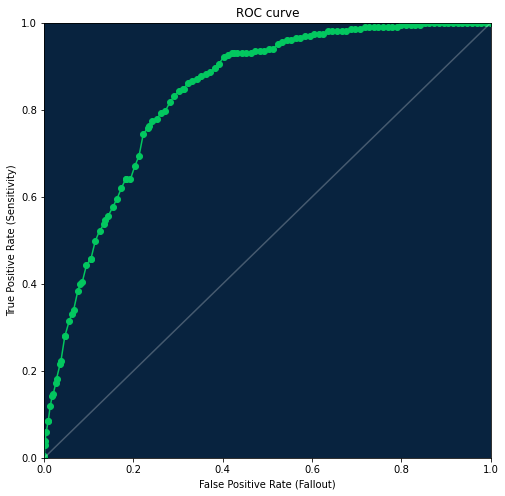

In [31]:
plot_dr_roc_curve(project, model=best_model, source="holdout")

### Confusion matrix

While the ROC curve illustrates model performance at different thresholds, the [confusion matrix](https://docs.datarobot.com/en/docs/modeling/analyze-models/evaluate/roc-curve-tab/confusion-matrix.html) provides a snapshot of model performance at the selected threshold. 

In [32]:
roc_df = get_dr_confusion_matrix(project=project, model=best_model, source="holdout")
roc_df

Predicted       Total
                 -    +       
Actual -     13798  671  14469
       +       146   57    203
Total        13944  728  14672

The confusion matrix above indicates that out of the 728 observations that predicted churn, 57 had churned (these are true positives).

### Feature Impact
[Feature Impact](https://docs.datarobot.com/en/docs/modeling/analyze-models/understand/feature-impact.html) measures how much worse a model’s error score would be if DataRobot made predictions after randomly shuffling a particular feature (also known as permutation importance).

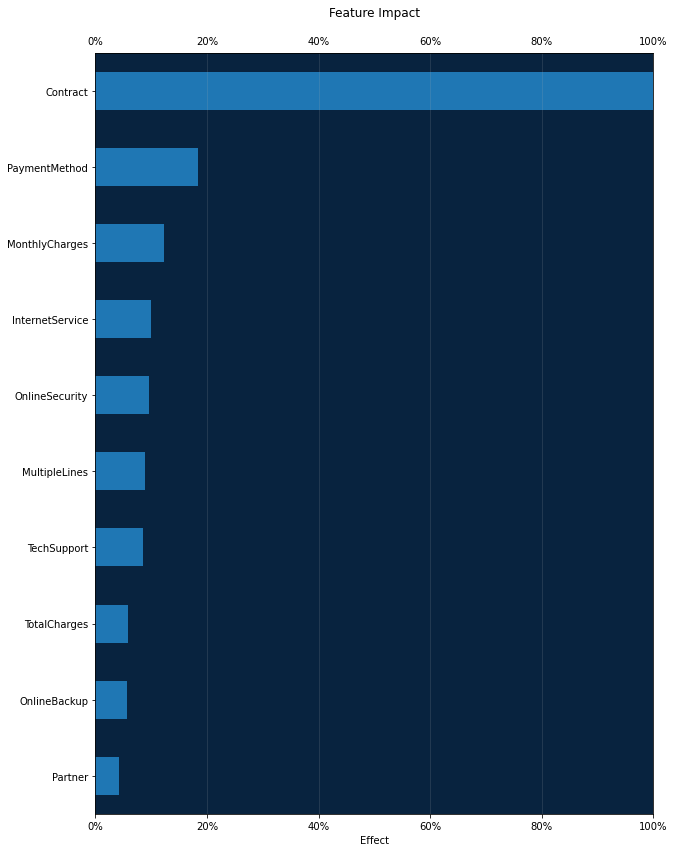

In [33]:
plot_feature_impact(model=best_model)

In the example above, `Contract` is the most impactful feature for predicting churn, followed by `PaymentMethod`. Feature Impact can help you understand the most important features. If some of those features can be controlled, the business can create strategies to prevent churn. 

## Make predictions

### Deploy a model to production

If you are happy with the model's performance, you can deploy it to a production environment with [MLOps](https://docs.datarobot.com/en/mlops/index.html).  Deploying the model will free up workers, as data scored through the deployment doesn't use any modeling workers. Furthermore, you are not restricted on the amount of data to score. Deployments also offer many model management benefits: monitoring service, data drift, model comparison, retraining, and more. 

For this use-case, the data is updated for each customer every month. Therefore, deploy the model and use batch predictions to score on the latest data every month.

In [34]:
prediction_server = dr.PredictionServer.list()[0]

# Get top performing model. Uncomment if this did not execute in the previous section
# model_top = sorted_by_metric(models, 'crossValidation', metric)[0]

deployment = dr.Deployment.create_from_learning_model(
    best_model.id,
    label="Telco Customer Churn",
    description="Test deployment",
    default_prediction_server_id=prediction_server.id,
)
deployment

Deployment(Telco Customer Churn)

At the end of every month, use the deployment to score the latest data. The ranked predictions can be passed on to an intervention team to take action on the high-churn risk customers.

### Configure batch predictions

After the model has been deployed, DataRobot creates an endpoint for real-time scoring. The deployment allows you to use DataRobot's batch prediction API to score large datasets with a deployed DataRobot model. 

The batch prediction API provides flexible intake and output options when scoring large datasets using prediction servers. The API is exposed through the DataRobot Public API and can be consumed using a REST-enabled client or Public API bindings for DataRobot's Python client.

#### Set the deployment ID

Before proceeding, provide the deployed model's deployment ID (retrieved from the deployment's [Overview tab](https://docs.datarobot.com/en/docs/mlops/monitor/dep-overview.html)).

In [24]:
deployment_id = "YOUR_DEPLOYMENT_ID"

#### Determine input and output options

DataRobot's batch prediction API allows you to score data from and to multiple sources. You can take advantage of the credentials and data sources you have already established through the UI for easy scoring. Credentials are usernames and passwords, and data sources are any databases with which you have previously established a connection (e.g., Snowflake). View the example code below outlining how to query credentials and data sources.

You can reference the full list of DataRobot's supported [input](https://docs.datarobot.com/en/docs/predictions/batch/batch-prediction-api/intake-options.html) and [output options](https://docs.datarobot.com/en/docs/predictions/batch/batch-prediction-api/output-options.html).

Reference the DataRobot documentation for more information about [data connections](https://docs.datarobot.com/en/docs/data/connect-data/data-conn.html).

The snippet below shows how you can query all credentials tied to a DataRobot account.

In [ ]:
dr.Credential.list()

The output above returns multiple sets of credentials. The alphanumeric string included in each item of the list is the credentials ID. You can use that ID to access credentials through the API.

The snippet below shows how you can query all data sources tied to a DataRobot account. The second line lists each datastore with an alphanumeric string; that is the datastore ID.

In [ ]:
dr.DataStore.list()
print(dr.DataStore.list()[0].id)

### Scoring examples

The snippets below demonstrate how to score data with the Batch Prediction API. Edit the `intake_settings` and `output_settings` to suit your needs. You can mix and match until you get the outcome you prefer.

#### Score from CSV to CSV

In [ ]:
# Scoring without Prediction Explanations
if False:
    dr.BatchPredictionJob.score(
        deployment_id,
        intake_settings={
            "type": "localFile",
            "file": "inputfile.csv",  # Provide the filepath, Pandas dataframe, or file-like object here
        },
        output_settings={"type": "localFile", "path": "outputfile.csv"},
    )

# Scoring with Prediction Explanations
if False:
    dr.BatchPredictionJob.score(
        deployment_id,
        intake_settings={
            "type": "localFile",
            "file": "inputfile.csv",  # Provide the filepath, Pandas dataframe, or file-like object here
        },
        output_settings={"type": "localFile", "path": "outputfile.csv"},
        max_explanations=3,  # Compute Prediction Explanations for the number of features indicated here
    )

#### Score from S3 to S3

In [ ]:
if False:
    dr.BatchPredictionJob.score(
        deployment_id,
        intake_settings={
            "type": "s3",
            "url": "s3://theos-test-bucket/lending_club_scoring.csv",  # Provide the URL of your datastore here
            "credential_id": "YOUR_CREDENTIAL_ID_FROM_ABOVE",  # Provide your credentials here
        },
        output_settings={
            "type": "s3",
            "url": "s3://theos-test-bucket/lending_club_scored2.csv",
            "credential_id": "YOUR_CREDENTIAL_ID_FROM_ABOVE",
        },
    )

#### Score from JDBC to JDBC

In [ ]:
if False:
    dr.BatchPredictionJob.score(
        deployment_id,
        intake_settings={
            "type": "jdbc",
            "table": "table_name",
            "schema": "public",
            "dataStoreId": data_store.id,  # Provide the ID of your datastore here
            "credentialId": cred.credential_id,  # Provide your credentials here
        },
        output_settings={
            "type": "jdbc",
            "table": "table_name",
            "schema": "public",
            "statementType": "insert",
            "dataStoreId": data_store.id,
            "credentialId": cred.credential_id,
        },
    )

### Cost benefit analysis

After retrieving prediction results, calculate the cost-benefit analysis of the intervention strategies based on model predictions. You can make certain assumptions about the cost of intervention strategies and their effectiveness to calculate the total cost of intervention. The revenue from the churned customers can be considered the revenue loss due to churn. Return on investment can be calculated from these two metrics - loss due to churn vs. cost of intervention.

Two intervention strategies are assumed to be present:

1. Low cost, less effective option: Cold calling
2. High cost, highly effective option: Discount coupon

In [35]:
# Cold call - costing $2 per customer with a 20% effectiveness to prevent churn
COST_OF_INTERVENTION_OPTION1 = 1
EFFECTIVENESS_OPTION1 = 0.1

In [36]:
# Discount coupon - costing $50 per customer (10% discount) with a 90% effectiveness to prevent churn
COST_OF_INTERVENTION_OPTION2 = 100
EFFECTIVENESS_OPTION2 = 0.95

In [37]:
# The number of customers would be split into two groups
# first group with cold call intervention, say 95% and
# the second group with discount coupon intervention
PERC_CUSTOMERS_OPTION1 = 0.95
PERC_CUSTOMERS_OPTION2 = 1 - PERC_CUSTOMERS_OPTION1

For simplicity, a constant value is assumed for the loss from a churned customer.

In [38]:
# Let us estimate the loss from a churned customer to be $1000 (Consider this to be LCV)
LOSS_DUE_TO_CHURN = 1000

### ROI calculation

Return on investment can be estimated based on the holdout data. All positive predictions are assumed to be sent for churn intervention.

In [39]:
roc = best_model.get_roc_curve("holdout")
best_threshold = roc.get_best_f1_threshold()
metrics = roc.estimate_threshold(best_threshold)
# best_model.get_roc_curve('holdout').estimate_threshold(best)

In [40]:
# Number of customers for each intervention
num_customers_option1 = (
    metrics["true_positive_score"] + metrics["false_positive_score"]
) * PERC_CUSTOMERS_OPTION1
num_customers_option2 = (
    metrics["true_positive_score"] + metrics["false_positive_score"]
) * PERC_CUSTOMERS_OPTION2

Calculate the cost of intervention with the assumptions on cost and the number of customers for each intervention strategy.

In [41]:
total_cost_of_intervention = (
    COST_OF_INTERVENTION_OPTION1 * num_customers_option1
    + COST_OF_INTERVENTION_OPTION2 * num_customers_option2
)

The benefit or prevented loss due to each strategy is the number of customers prevented from churning. Calculate this using the assumptions on loss of revenue from a churned customer, the effectiveness of the intervention strategy, and the number of correct predictions from the model.

In [42]:
prevented_loss_option1 = LOSS_DUE_TO_CHURN * (
    EFFECTIVENESS_OPTION1 * metrics["true_positive_score"] * PERC_CUSTOMERS_OPTION1
)
prevented_loss_option2 = LOSS_DUE_TO_CHURN * (
    EFFECTIVENESS_OPTION2 * metrics["true_positive_score"] * PERC_CUSTOMERS_OPTION2
)

In [43]:
total_prevented_loss = prevented_loss_option1 + prevented_loss_option2

In [44]:
roi = total_prevented_loss / total_cost_of_intervention - 1
print(f"ROI from the intervention: {roi*100: .0f}%")

ROI from the intervention:  88%
